In [27]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from torchvision import transforms
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def load_image_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def preprocess(img, w_max, gamma):
    h, w, c = img.shape
    wf, hf = w_max, 1 if int(h*w_max/w) == 0 else int(h*w_max/w)
    img = cv2.resize(img, (wf, hf), interpolation = cv2.INTER_AREA)
    img = 255*(img/255.)**gamma
    img = img.astype(np.uint8)
    return img, (w, h), (wf, hf)

In [4]:
def load_image(image_path, w_max, gamma, hardcoded_range):
    img = load_image_from_path(image_path)
    hd1, hd2 = hardcoded_range
    hardcoded_img = img[hd1: hd2]
    img, (w, h), (wf, hf) = preprocess(img, w_max, gamma)
    hardcoded_img, (_, _), (_, _) = preprocess(hardcoded_img, w_max, gamma)
    wr, hr = wf/w, hf/h
    return img, hardcoded_img, (wf, hf), (wr, hr)

def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img


def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img


In [5]:
def generate_para(img, threshold, kernel_dims):
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    para_list = []
    para_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        para_list.append([x, y, w, h])
        para_images.append(img[y:y+h, x:x+w])
        break
        
    return para_images[0], para_list[0]

In [6]:
def get_img_and_vars(image_path, w_max, gamma, hardcoded_range, threshold, kernel_dims):
    img, himg, (wf, hf), (wr, hr) = load_image(image_path, w_max, gamma, hardcoded_range)
    para_img, (x,y,w,h) = generate_para(himg, threshold, kernel_dims)
    y = y + HARDCODED_RANGE[0]*hr
    y = int(y)
    return img, (x,y,w,h), (x/wf, y/hf, w/wf, h/hf)

In [7]:
image_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])

def return_tensor(image):
    image = fromarray(image)
    return image_transform(image)

---

In [8]:
GAMMA = 2
W_MAX = 1000
THRESHOLD = 40
KERNEL_DIMS = (85,85)
HARDCODED_RANGE = (710,2800)

In [9]:
image_path = '/kaggle/input/iam-handwritten-forms-dataset/data/000/a01-000u.png'

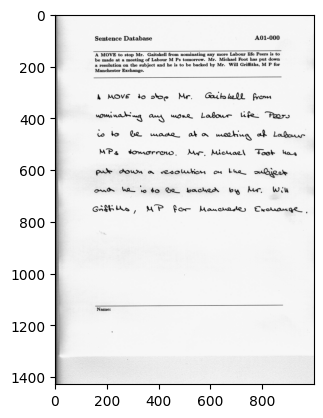

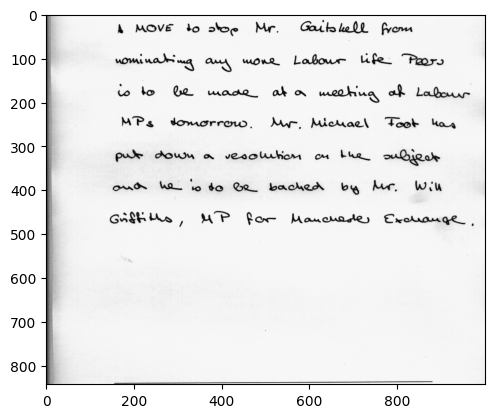

In [10]:
img, himg, (wf, hf), (wr, hr) = load_image(image_path, W_MAX, GAMMA, HARDCODED_RANGE)
plt.imshow(img)
plt.show()
plt.imshow(himg)
plt.show()

(104, 286, 896, 527)


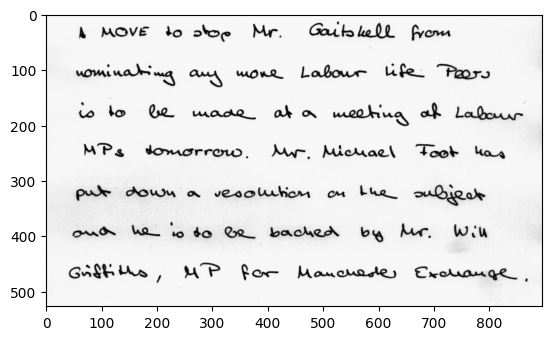

In [11]:
para_img, (x,y,w,h) = generate_para(himg, THRESHOLD, KERNEL_DIMS)
plt.imshow(para_img)
y = y + HARDCODED_RANGE[0]*hr
y = int(y)
print((x,y,w,h))
plt.show()

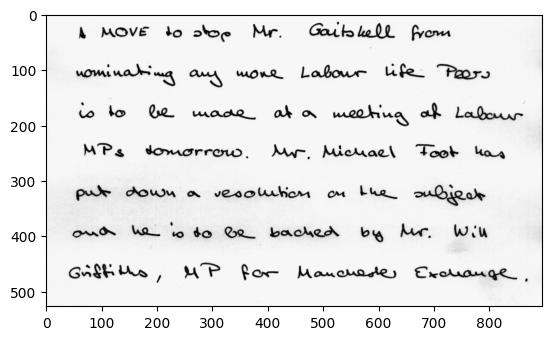

In [12]:
plt.imshow(img[y:y+h, x:x+w])
plt.show()

In [13]:
img, (x,y,w,h), _ = get_img_and_vars(image_path, W_MAX, GAMMA, HARDCODED_RANGE, THRESHOLD, KERNEL_DIMS)

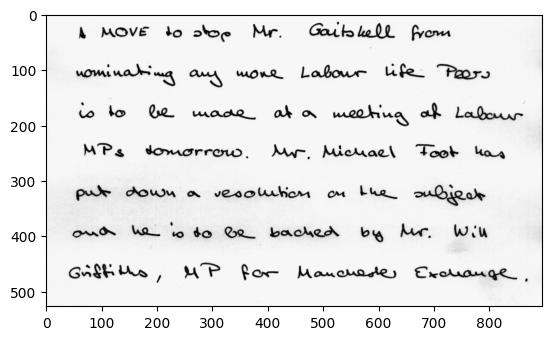

In [14]:
plt.imshow(img[y:y+h, x:x+w])
plt.show()

/kaggle/input/iam-handwritten-forms-dataset/data/515/m01-115.png


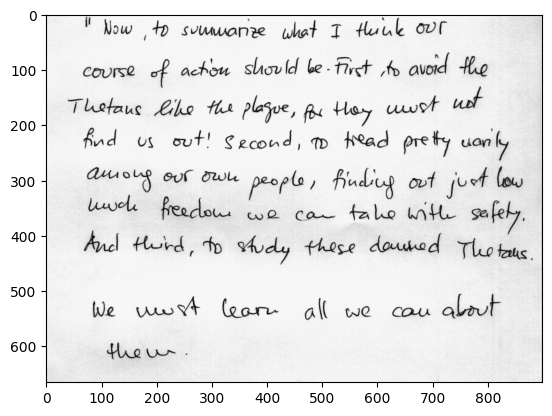

In [15]:
maindir = '/kaggle/input/iam-handwritten-forms-dataset/data'
for subdir in os.listdir(maindir):
    subdir_path = os.path.join(maindir, subdir)
    for img_file in os.listdir(subdir_path):
        img_file_path = os.path.join(subdir_path, img_file)
        print(img_file_path)
        img, himg, (wf, hf), (wr, hr) = load_image(img_file_path, W_MAX, GAMMA, HARDCODED_RANGE)
        para_img, (x,y,w,h) = generate_para(himg, THRESHOLD, KERNEL_DIMS)
        y = y + HARDCODED_RANGE[0]*hr
        y = int(y)
        plt.imshow(img[y:y+h, x:x+w])
        plt.show()
        break
    break

In [16]:
# dataset_image_paths = []
# dataset_labels_x = []
# dataset_labels_y = []
# dataset_labels_w = []
# dataset_labels_h = []
# maindir = '/kaggle/input/iam-handwritten-forms-dataset/data'
# for subdir in os.listdir(maindir):
#     subdir_path = os.path.join(maindir, subdir)
#     for img_file in os.listdir(subdir_path):
#         img_file_path = os.path.join(subdir_path, img_file)
#         img, (_x,_y,_w,_h), (x,y,w,h) = get_img_and_vars(img_file_path, W_MAX, GAMMA, HARDCODED_RANGE, THRESHOLD, KERNEL_DIMS)
#         if _w > 100 and _h > 100:
#             dataset_image_paths.append(img_file_path)
#             dataset_labels_x.append(x)
#             dataset_labels_y.append(y)
#             dataset_labels_w.append(w)
#             dataset_labels_h.append(h)

In [17]:
# df = pd.DataFrame({
#     'image_path':dataset_image_paths,
#     'x':dataset_labels_x,
#     'y':dataset_labels_y,
#     'w':dataset_labels_w,
#     'h':dataset_labels_h
# })
# df.to_csv('paraseg.csv')

In [18]:
df = pd.read_csv('/kaggle/input/paraseg/paraseg.csv')

In [19]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.image_paths = df['image_path'].tolist()
        x = df['x'].tolist()
        y = df['y'].tolist()
        w = df['w'].tolist()
        h = df['h'].tolist()
        
        labels = np.array([x, y, w, h])
        self.labels = labels.T.tolist()

    def __len__(self):
        return df.shape[0]
    
    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx], self.labels[idx]
        img = load_image_from_path(img_path)
        img, _, _ = preprocess(img, W_MAX, GAMMA)
        img_tensor = return_tensor(img)
        return img_tensor, label

In [20]:
dataset = CustomDataset(df)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [21]:
for each in data_loader:
    img = each[0][0]
    x = each[1][0][0]
    y = each[1][1][0]
    w = each[1][2][0]
    h = each[1][3][0]
    print(img.shape)
    print(x,y,w,h)
    break

torch.Size([1, 1428, 1000])
tensor(0.0880, dtype=torch.float64) tensor(0.2003, dtype=torch.float64) tensor(0.8570, dtype=torch.float64) tensor(0.5231, dtype=torch.float64)


In [22]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()

        # Load pre-trained ResNet34 model
        self.resnet = models.resnet34(pretrained=True)

        # Modify the first convolutional layer to accommodate grayscale images
        conv1_weight = self.resnet.conv1.weight.data
        conv1_weight = conv1_weight.mean(dim=1, keepdim=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight.data = conv1_weight

        # Remove the last fully connected layer of ResNet34
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Freeze the ResNet layers so they won't be trained
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Add fully connected layers
        self.fc1 = nn.Linear(512, 64)  # ResNet34 outputs 512 features
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)  # Output layer with 4 units for bounding box coordinates
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through ResNet layers
        x = self.resnet(x)

        # Flatten the output of ResNet
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)  # Applying sigmoid activation for bounding box coordinates

        return x

In [23]:
resnet = ResNet34()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s] 


In [24]:
def train(model, criterion, optimizer, data_loader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = model.to(device)
    model.train()

    total_batches = len(data_loader)
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (img, target) in enumerate(data_loader):
            target = torch.stack(target, dim=1).float()
            img, target = img.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(img)

            # Separate the ground truth bounding box coordinates
            gt_x, gt_y, gt_w, gt_h = target[:, 0], target[:, 1], target[:, 2], target[:, 3]

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * img.size(0)
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item()}')

        epoch_loss /= len(data_loader.dataset)
        losses.append(epoch_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss}')

    # Save the model
    torch.save(model.state_dict(), 'model.pth')

    # Plot the loss curve
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

Using device: cuda
Epoch [1/10], Batch [1/48], Loss: 0.08735334128141403
Epoch [1/10], Batch [2/48], Loss: 0.06599670648574829
Epoch [1/10], Batch [3/48], Loss: 0.04890696331858635
Epoch [1/10], Batch [4/48], Loss: 0.03592848777770996
Epoch [1/10], Batch [5/48], Loss: 0.0258642565459013
Epoch [1/10], Batch [6/48], Loss: 0.01767810992896557
Epoch [1/10], Batch [7/48], Loss: 0.009109245613217354
Epoch [1/10], Batch [8/48], Loss: 0.00530089158564806
Epoch [1/10], Batch [9/48], Loss: 0.0023765191435813904
Epoch [1/10], Batch [10/48], Loss: 0.0037827957421541214
Epoch [1/10], Batch [11/48], Loss: 0.0033722249791026115
Epoch [1/10], Batch [12/48], Loss: 0.00424449797719717
Epoch [1/10], Batch [13/48], Loss: 0.005993573926389217
Epoch [1/10], Batch [14/48], Loss: 0.006056801415979862
Epoch [1/10], Batch [15/48], Loss: 0.005909893661737442
Epoch [1/10], Batch [16/48], Loss: 0.006558307446539402
Epoch [1/10], Batch [17/48], Loss: 0.0068238782696425915
Epoch [1/10], Batch [18/48], Loss: 0.006280

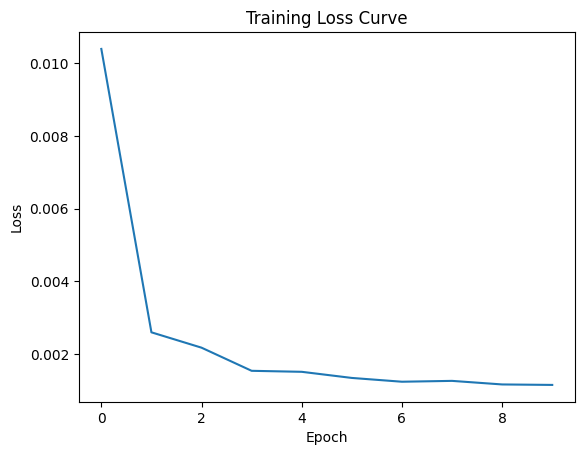

In [25]:
model = ResNet34()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train(model, criterion, optimizer, data_loader, num_epochs)

In [31]:
torch.save(model.state_dict(), 'model.pth')

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
model = ResNet34().to(device)

model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [40]:
model_path = '/kaggle/working/para_seg_model.pth'
torch.save(model.state_dict(), model_path)

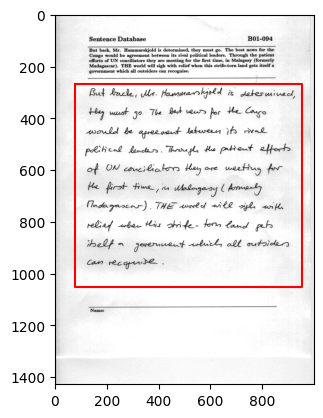

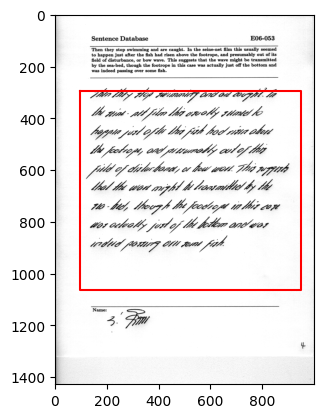

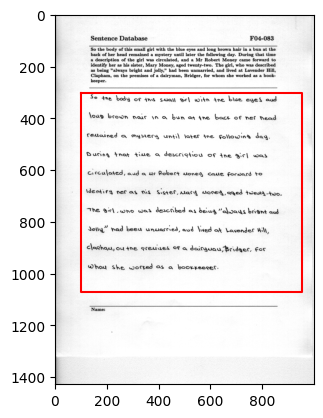

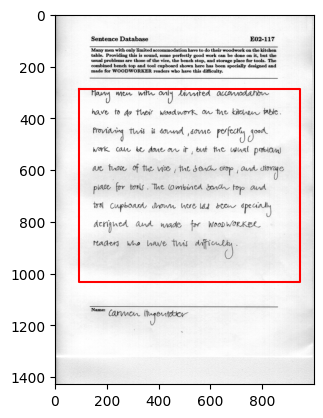

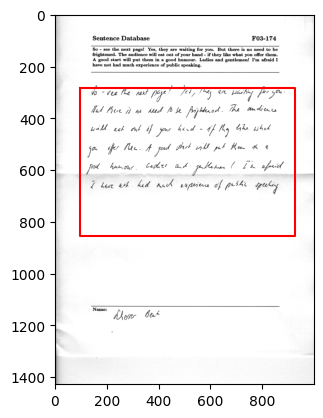

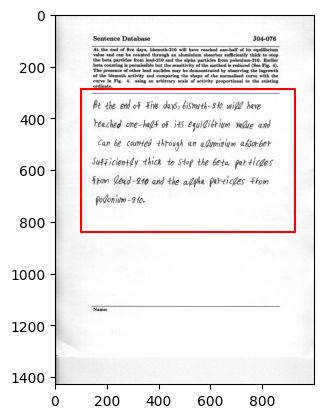

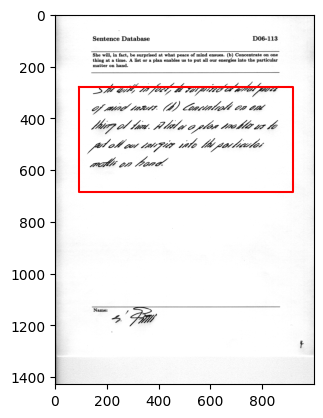

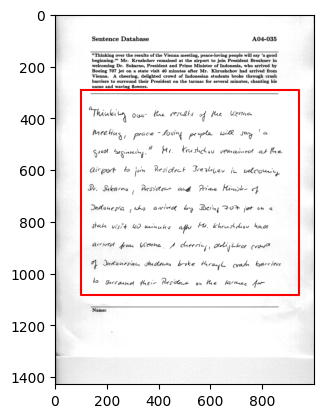

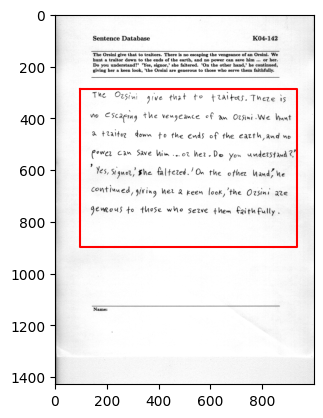

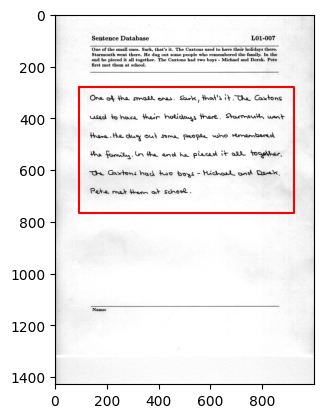

In [91]:
for images, _ in data_loader:
    images = images.to(device)
    y_hat = model(images)
    break
    
for i in range(10):
    x, y, w, h = y_hat[i].detach()

    x = x.cpu().numpy()
    y = y.cpu().numpy()
    w = w.cpu().numpy()
    h = h.cpu().numpy()

    image = images[i]

    height, width = image.shape[1], image.shape[2]

    x_left_top, y_left_top = x * width, y * height
    width, height = w * width, h * height

    x_right_top = x_left_top + width
    y_left_bottom = y_left_top + height
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.plot([x_left_top, x_left_top, x_right_top, x_right_top, x_left_top],
             [y_left_top, y_left_bottom, y_left_bottom, y_left_top, y_left_top],
             color='red')

    plt.show()